In [1]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz

--2024-11-19 14:07:50--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-11-19 14:07:51--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: 'images.tar.gz'

images.tar.gz       100%[===================>] 755.23M  28.2MB/s    in 28s     

2024-11-19 14:08:19 (27.2 MB/s) - 'images.tar.gz' saved [791918971/791918971]



In [2]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2024-11-19 14:08:20--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://thor.robots.ox.ac.uk/pets/annotations.tar.gz [following]
--2024-11-19 14:08:20--  https://thor.robots.ox.ac.uk/pets/annotations.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: 'annotations.tar.gz'

annotations.tar.gz  100%[===================>]  18.28M  12.8MB/s    in 1.4s    

2024-11-19 14:08:22 (12.8 MB/s) - 'annotations.tar.gz' saved [19173078/19173078]



In [3]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17


# Importing libraries

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Conv2DTranspose,concatenate,BatchNormalization, ReLU 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
import albumentations as A
from tensorflow.keras.utils import to_categorical

# defining constants

In [5]:
n_h = 128
n_w = 128
n_c = 3
input_shape = (n_h, n_w, n_c)
num_classes = 3
#############
batch_size = 64
lr = 1e-3
epochs = 30
val_size = 0.2
#############
shuffle = True
seed = 42
reshuffle_each_iteration = True
tf.random.set_seed(seed)
np.random.seed(seed)
results_path = '/kaggle/working'
name = 'U-Net'

# define the Transformations and Pipline and Callbacks

In [6]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p = 0.5),
    A.Rotate(limit=40),
    
])
def augment_func(image, mask):
    trans_image, trans_mask= transform(image = image, mask = mask).values()
    return trans_image, trans_mask

In [346]:
def data_pipeline(input:tuple, parse_function,train_preprocess, batch_size, shuffle, seed, reshuffle_each_iteration, aug=True):
  with tf.device('/cpu:0'):
    data_set = tf.data.Dataset.from_tensor_slices(input)
    if shuffle:
      data_set = data_set.shuffle(len(input[0]), seed=seed, reshuffle_each_iteration=reshuffle_each_iteration)
    data_set = data_set.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if aug:
        data_set = data_set.map(train_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data_set = data_set.map(fixup_shape)
    data_set = data_set.batch(batch_size)
    data_set = data_set.prefetch(1)
  return data_set


def parse_function(file_image_path, file_mask_path):
    # Image preprocessing
    image_string = tf.io.read_file(file_image_path)
    image = tf.image.decode_image(image_string, channels=3, expand_animations=False)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Scale to [0, 1]


    image = tf.image.resize(image, [n_h, n_w])  # Resize to the desired dimensions
    # Mask preprocessing
    mask_string = tf.io.read_file(file_mask_path)
    mask = tf.image.decode_image(mask_string, channels=3, expand_animations=False)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # Convert to a single channel
    mask = mask - 1

    mask = tf.image.resize(mask, [n_h, n_w], 'nearest')  # Resize to the desired dimensions
    mask = tf.cast(mask, tf.int32)  # Ensure mask has integer labels

    return image, mask


def train_preprocess(image, mask):


    # Perform augmentations
    image, mask= tf.numpy_function(func= augment_func, inp = [image,mask],Tout = [tf.float32,tf.int32])

    image = tf.clip_by_value(image, 0.0, 1.0)
        # Map mask values to ensure they are 0, 1, or 2
    mask = tf.clip_by_value(mask, 0, 2)  # Clip mask values within the valid range
    mask = tf.cast(mask, tf.int32)  # Ensure the mask remains integer

    return image, mask

def fixup_shape(image, mask):
    # image.set_shape([n_h, n_w, 3])
    mask= to_categorical(mask,num_classes=n_c)
    image = tf.reshape(image,(n_h,n_w,3))
    mask = tf.reshape(mask,(n_h,n_w,n_c))
    
    # mask.set_shape([n_h, n_w, n_c])
    return image, mask

In [347]:
def c_callbacks(outdir, name='U-Net'):
    # checkpoint_cb = ModelCheckpoint(outdir+"/"+name+'-{epoch:02d}-{val_accuracy:.2f}'+".keras", monitor='val_accuracy',
    #                                 verbose=1, save_best_only=True, mode='max',
    #                                 save_weights_only=False, save_freq='epoch')
    
    rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

    early_stopping_cb = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=10,
                                      verbose=1, mode="max", baseline=None,
                                      start_from_epoch=0, restore_best_weights=True)

    logger_cb = CSVLogger(outdir+"/"+name+"_log.csv", separator=",", append=False)
    
    return [early_stopping_cb, rlrop, logger_cb]



# Lets Extract and prepare our datasets

In [328]:
import tarfile

# Path to the tar file you uploaded
file_path = '/kaggle/working/annotations.tar.gz'

# Extracting the tar file
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path='/kaggle/working/') 

file_path = '/kaggle/working/images.tar.gz'

# Extracting the tar file
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path='/kaggle/working/') 

print("Extraction complete!")

Extraction complete!


In [348]:
df = pd.read_csv('/kaggle/working/annotations/trainval.txt',sep = ' ', header= None)
all_paths_Images = []
all_paths_mask = []
for Name in df[0].values:
   
    # images
    imageFileName = '/kaggle/working/images/'+Name+'.jpg'
    all_paths_Images.append(imageFileName)
    # mask
    maskFileName = '/kaggle/working/annotations/trimaps/'+Name+'.png'
    all_paths_mask.append(maskFileName)
len(all_paths_Images), len(all_paths_mask)

(3680, 3680)

In [349]:
df = pd.read_csv('/kaggle/working/annotations/test.txt',sep = ' ', header= None)
for Name in df[0].values:
    # images
    imageFileName = '/kaggle/working/images/'+Name+'.jpg'
    all_paths_Images.append(imageFileName)
    # mask
    maskFileName = '/kaggle/working/annotations/trimaps/'+Name+'.png'
    all_paths_mask.append(maskFileName)
len(all_paths_Images), len(all_paths_mask)

(7349, 7349)

In [350]:
train_filepaths_images, test_filepaths_images,train_filepaths_masks,test_filepaths_masks = train_test_split(all_paths_Images,all_paths_mask,  test_size=0.2, random_state=123, shuffle=True, stratify=None)
train_filepaths_images, valid_filepaths_images,train_filepaths_masks,valid_filepaths_masks = train_test_split(train_filepaths_images,train_filepaths_masks,  test_size=0.2, random_state=123, shuffle=True, stratify=None)

training_set = data_pipeline((train_filepaths_images,train_filepaths_masks), parse_function,train_preprocess, 64, True, 123, True, True)
validation_set = data_pipeline((valid_filepaths_images,valid_filepaths_masks ), parse_function,train_preprocess, 64, False, 123, False, False)
test_set = data_pipeline((test_filepaths_images,test_filepaths_masks ), parse_function,train_preprocess, 64, False, 123, False, False)

In [351]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

# Display sample of images after applying augmentaions

In [357]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i],cmap = 'gray')
        plt.axis('off')
    plt.show()

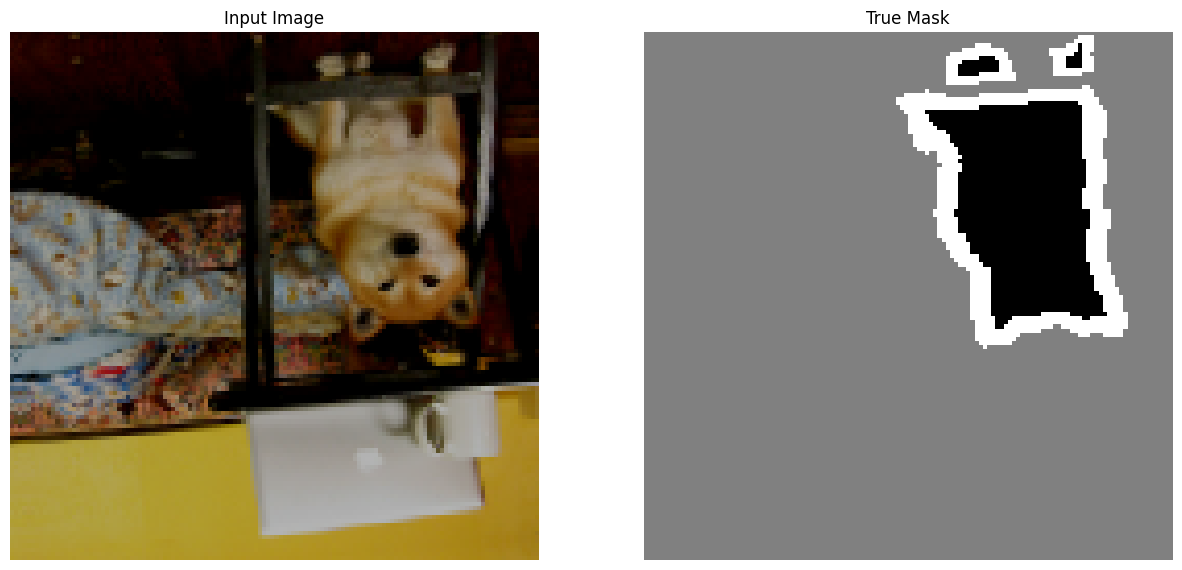

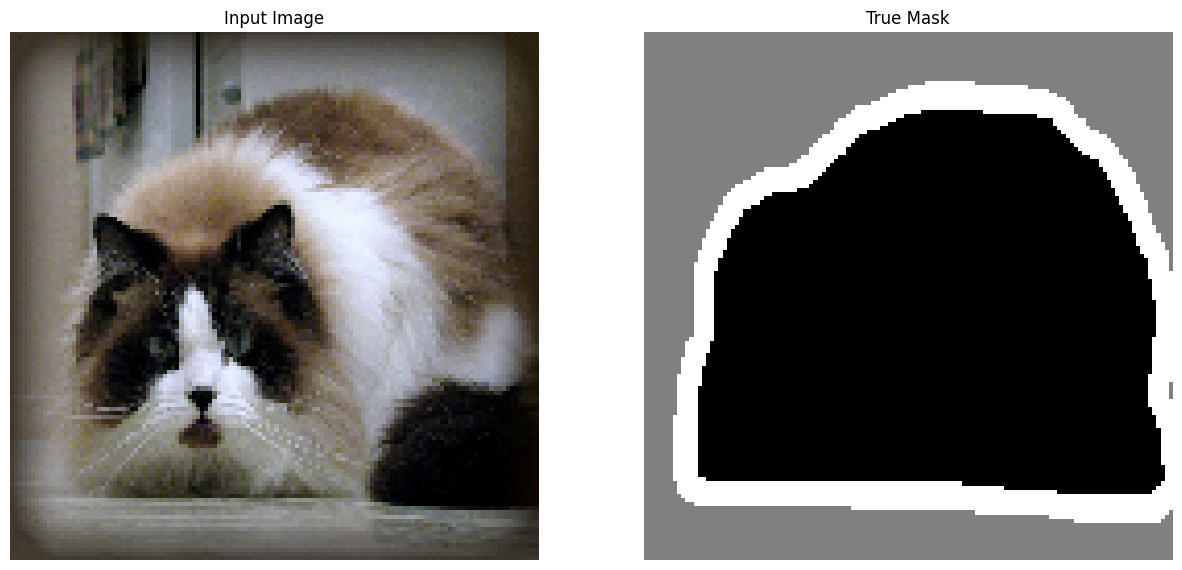

In [384]:
needed = 2
for (image,mask) in  training_set.unbatch().take(needed):
    display([image,tf.argmax(mask, axis=-1)])
    # print(image,mask)
    # j=0

# Lets display and learn about mask

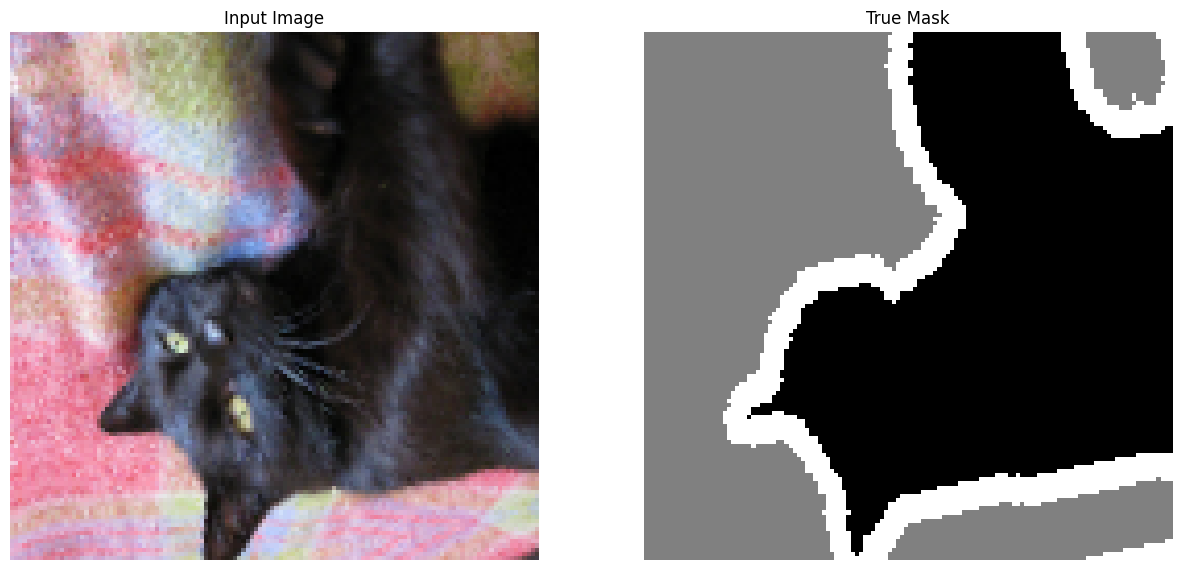

In [382]:
example = next(iter(training_set.unbatch().take(1)))
image, mask = example  # Unpack image and mask
display([image, tf.argmax(mask, axis=-1)])

# lets load one image and print it in a reduced size

In [381]:
x = cv2.resize(mask.numpy(), (16,16), interpolation=cv2.INTER_NEAREST)
tf.argmax(x, axis=-1)

<tf.Tensor: shape=(16, 16), dtype=int64, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1]])>

* value = 0 - main object
* value = 1 - background
* value = 2 - border of the object 

# Buliding our module ; we will construct U-Net from scratch 

1. **First construct the Encoder** 
2. **Second the Bottleneck output**
3. **Third the Decoder**
4. **Integrating them in one function**

In [361]:
def conv_block(inputs=None, n_filters=64, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='linear',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    x = BatchNormalization()(conv)
    conv = ReLU()(x)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='linear',
                  padding='same',
                  kernel_initializer= 'he_normal')(x)
    x = BatchNormalization()(conv)
    conv= ReLU()(x)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [362]:

def upsampling_block(expansive_input, contractive_input, n_filters=64):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

In [363]:
def unet_model(input_size=(128, 128, 3), n_filters=64, n_classes=3):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.6)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.6, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [364]:
unet = unet_model((n_h, n_w, n_c))

In [365]:
unet.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_88[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_89[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 64, 64,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_18… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_90[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_91[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 32, 32,    │          0 │ re_lu_35[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_19… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_92[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_93[0][0] 

 Total params: 34,566,275 (131.86 MB)

 Trainable params: 34,558,339 (131.83 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [366]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [371]:
unet.fit(training_set,validation_data=validation_set, batch_size=64,epochs=40 ,verbose=1,callbacks=c_callbacks(outdir=results_path, name=name+'V0'))

Epoch 1/40
43/74 ━━━━━━━━━━━━━━━━━━━━ 12s 404ms/step - accuracy: 0.9012 - loss: 0.2557

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


50/74 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step - accuracy: 0.9011 - loss: 0.2557 

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.9011 - loss: 0.2558 - val_accuracy: 0.9023 - val_loss: 0.2584 - learning_rate: 1.0000e-04
Epoch 2/40
26/74 ━━━━━━━━━━━━━━━━━━━━ 19s 404ms/step - accuracy: 0.9023 - loss: 0.2542

Corrupt JPEG data: premature end of data segment


67/74 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.9021 - loss: 0.2552

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.9021 - loss: 0.2553 - val_accuracy: 0.9029 - val_loss: 0.2560 - learning_rate: 1.0000e-04
Epoch 3/40
35/74 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - accuracy: 0.9023 - loss: 0.2510

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


56/74 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - accuracy: 0.9025 - loss: 0.2514

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.9026 - loss: 0.2513 - val_accuracy: 0.9030 - val_loss: 0.2562 - learning_rate: 1.0000e-04
Epoch 4/40
34/74 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.9021 - loss: 0.2505

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


49/74 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.9021 - loss: 0.2515

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 442ms/step - accuracy: 0.9021 - loss: 0.2517 - val_accuracy: 0.9049 - val_loss: 0.2517 - learning_rate: 1.0000e-04
Epoch 5/40
 2/74 ━━━━━━━━━━━━━━━━━━━━ 29s 411ms/step - accuracy: 0.9103 - loss: 0.2302

Corrupt JPEG data: premature end of data segment


56/74 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - accuracy: 0.9024 - loss: 0.2497

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 444ms/step - accuracy: 0.9024 - loss: 0.2499 - val_accuracy: 0.9047 - val_loss: 0.2519 - learning_rate: 1.0000e-04
Epoch 6/40
23/74 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - accuracy: 0.9053 - loss: 0.2459

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


40/74 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.9044 - loss: 0.2484

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 444ms/step - accuracy: 0.9039 - loss: 0.2500 - val_accuracy: 0.9038 - val_loss: 0.2550 - learning_rate: 1.0000e-04
Epoch 7/40
10/74 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.9019 - loss: 0.2585

Corrupt JPEG data: premature end of data segment


47/74 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.9029 - loss: 0.2528

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 444ms/step - accuracy: 0.9033 - loss: 0.2512 - val_accuracy: 0.9033 - val_loss: 0.2563 - learning_rate: 1.0000e-04
Epoch 8/40
10/74 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.8996 - loss: 0.2550

Corrupt JPEG data: premature end of data segment


21/74 ━━━━━━━━━━━━━━━━━━━━ 21s 405ms/step - accuracy: 0.9020 - loss: 0.2505

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.9034 - loss: 0.2484 - val_accuracy: 0.9035 - val_loss: 0.2552 - learning_rate: 1.0000e-04
Epoch 9/40
 6/74 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.9060 - loss: 0.2452

Corrupt JPEG data: premature end of data segment


21/74 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - accuracy: 0.9030 - loss: 0.2536

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9031 - loss: 0.2526
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.9031 - loss: 0.2525 - val_accuracy: 0.9027 - val_loss: 0.2594 - learning_rate: 1.0000e-04
Epoch 10/40
 6/74 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9041 - loss: 0.2482

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


67/74 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.9052 - loss: 0.2459

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.9053 - loss: 0.2457 - val_accuracy: 0.9058 - val_loss: 0.2504 - learning_rate: 1.0000e-05
Epoch 11/40
10/74 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.9039 - loss: 0.2503

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


16/74 ━━━━━━━━━━━━━━━━━━━━ 23s 405ms/step - accuracy: 0.9037 - loss: 0.2503

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.9050 - loss: 0.2460 - val_accuracy: 0.9057 - val_loss: 0.2508 - learning_rate: 1.0000e-05
Epoch 12/40
42/74 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.9060 - loss: 0.2428

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


51/74 ━━━━━━━━━━━━━━━━━━━━ 9s 405ms/step - accuracy: 0.9061 - loss: 0.2427

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9059 - loss: 0.2430 - val_accuracy: 0.9057 - val_loss: 0.2510 - learning_rate: 1.0000e-05
Epoch 13/40
34/74 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.9062 - loss: 0.2411

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


38/74 ━━━━━━━━━━━━━━━━━━━━ 14s 405ms/step - accuracy: 0.9063 - loss: 0.2410

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.9061 - loss: 0.2424 - val_accuracy: 0.9054 - val_loss: 0.2514 - learning_rate: 1.0000e-05
Epoch 14/40
 6/74 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9060 - loss: 0.2471

Corrupt JPEG data: premature end of data segment


37/74 ━━━━━━━━━━━━━━━━━━━━ 14s 405ms/step - accuracy: 0.9047 - loss: 0.2463

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9050 - loss: 0.2449 - val_accuracy: 0.9051 - val_loss: 0.2525 - learning_rate: 1.0000e-05
Epoch 15/40
42/74 ━━━━━━━━━━━━━━━━━━━━ 12s 404ms/step - accuracy: 0.9067 - loss: 0.2391

Corrupt JPEG data: premature end of data segment


54/74 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - accuracy: 0.9065 - loss: 0.2394

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9064 - loss: 0.2401
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9063 - loss: 0.2402 - val_accuracy: 0.9048 - val_loss: 0.2537 - learning_rate: 1.0000e-05
Epoch 16/40
 4/74 ━━━━━━━━━━━━━━━━━━━━ 28s 406ms/step - accuracy: 0.8952 - loss: 0.2728

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


22/74 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - accuracy: 0.9015 - loss: 0.2535

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9043 - loss: 0.2468 - val_accuracy: 0.9050 - val_loss: 0.2530 - learning_rate: 1.0000e-06
Epoch 17/40
11/74 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.9076 - loss: 0.2330

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


48/74 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.9069 - loss: 0.2377

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.9063 - loss: 0.2400 - val_accuracy: 0.9051 - val_loss: 0.2526 - learning_rate: 1.0000e-06
Epoch 18/40
47/74 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.9060 - loss: 0.2449

Corrupt JPEG data: premature end of data segment


62/74 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.9062 - loss: 0.2440

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9064 - loss: 0.2435 - val_accuracy: 0.9053 - val_loss: 0.2522 - learning_rate: 1.0000e-06
Epoch 19/40
17/74 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.9022 - loss: 0.2463

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


38/74 ━━━━━━━━━━━━━━━━━━━━ 14s 405ms/step - accuracy: 0.9031 - loss: 0.2468

Corrupt JPEG data: premature end of data segment


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9043 - loss: 0.2450 - val_accuracy: 0.9052 - val_loss: 0.2524 - learning_rate: 1.0000e-06
Epoch 20/40
34/74 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.9074 - loss: 0.2382

Corrupt JPEG data: premature end of data segment


38/74 ━━━━━━━━━━━━━━━━━━━━ 14s 405ms/step - accuracy: 0.9073 - loss: 0.2383

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9069 - loss: 0.2397
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9069 - loss: 0.2397 - val_accuracy: 0.9053 - val_loss: 0.2521 - learning_rate: 1.0000e-06
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.


# Lets evaluate our model in training, validation, test set

In [372]:
unet.evaluate(training_set)
# [0.27784061431884766, 0.8927797675132751]

10/74 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.9006 - loss: 0.2537

Corrupt JPEG data: premature end of data segment


66/74 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.9026 - loss: 0.2511

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.9026 - loss: 0.2510


[0.25037193298339844, 0.9029221534729004]

In [373]:
unet.evaluate(validation_set)
# [0.2623891830444336, 0.9000696539878845]

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.9091 - loss: 0.2367


[0.250448614358902, 0.9057860374450684]

In [374]:
unet.evaluate(test_set)
# [0.2601363956928253, 0.8988649845123291]

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9060 - loss: 0.2398


[0.24176982045173645, 0.9061156511306763]

# Ploting our model Training 

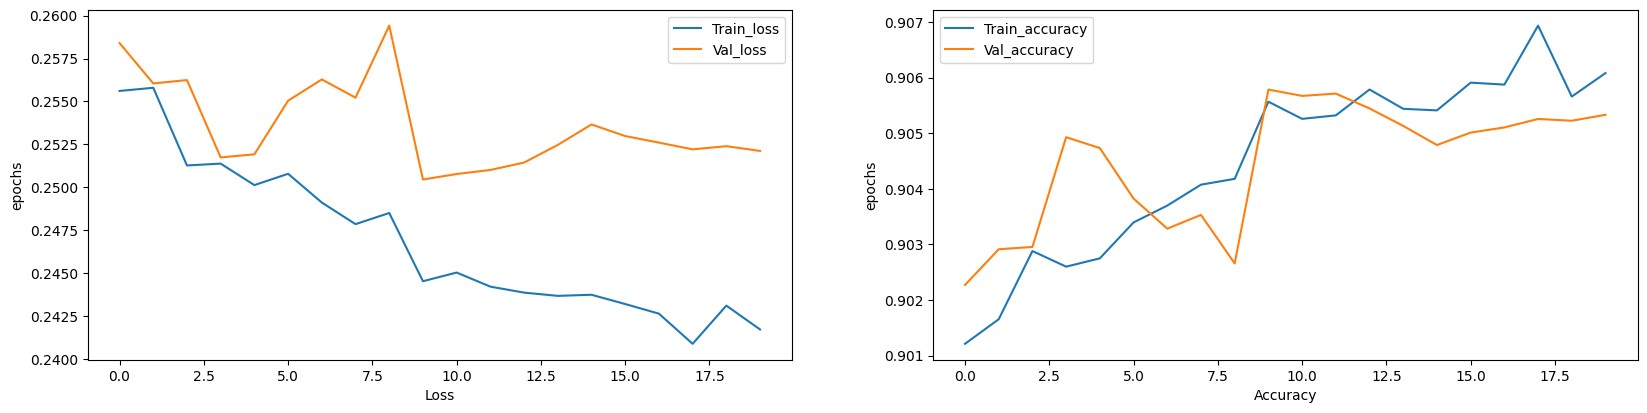

In [375]:
import os 
hist1 = pd.read_csv(os.path.join(results_path, name+'V0'+'_log.csv'))

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(hist1['epoch'], hist1['loss'], label='Train_loss')
plt.plot(hist1['epoch'], hist1['val_loss'], label='Val_loss')
plt.xlabel('Loss')
plt.ylabel('epochs')
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist1['epoch'], hist1['accuracy'], label='Train_accuracy')
plt.plot(hist1['epoch'], hist1['val_accuracy'], label='Val_accuracy')
plt.xlabel('Accuracy')
plt.ylabel('epochs')
plt.legend()
plt.show()

In [376]:
unet.save('/kaggle/working/unetV1.keras')

In [377]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    return pred_mask[0]


In [402]:
import tensorflow as tf
import numpy as np
import cv2

def creat_masked_images(img, mask, pred_mask):
    """
    Creates a masked version of the image and mask using predictions.
    
    Args:
        img (tf.Tensor): Input image tensor.
        mask (tf.Tensor): Ground truth mask tensor.
        pred_mask (tf.Tensor): Predicted mask tensor.
    
    Returns:
        Tuple: (masked_img_ground_truth, masked_img_pred)
    """
    # Convert tensors to NumPy arrays for OpenCV processing
    img_np = img.numpy()  # Convert image to NumPy
    mask_np = mask.numpy().astype(np.uint8)  # Convert mask to NumPy
    pred_mask_np = pred_mask.numpy().astype(np.uint8)  # Convert predicted mask to NumPy

    # Mask preprocessing for ground truth
    mask_np = np.where((mask_np == 0) | (mask_np == 2), 255, 0).astype(np.uint8)

    # Mask preprocessing for predictions
    pred_mask_np = np.where((pred_mask_np == 0) | (pred_mask_np == 2), 255, 0).astype(np.uint8)

    # Apply masks using OpenCV
    masked_img_ground_truth = cv2.bitwise_and(img_np, img_np, mask=mask_np)
    masked_img_pred = cv2.bitwise_and(img_np, img_np, mask=pred_mask_np)

    return masked_img_ground_truth, masked_img_pred


# Lets see what the predicted mask looks like 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


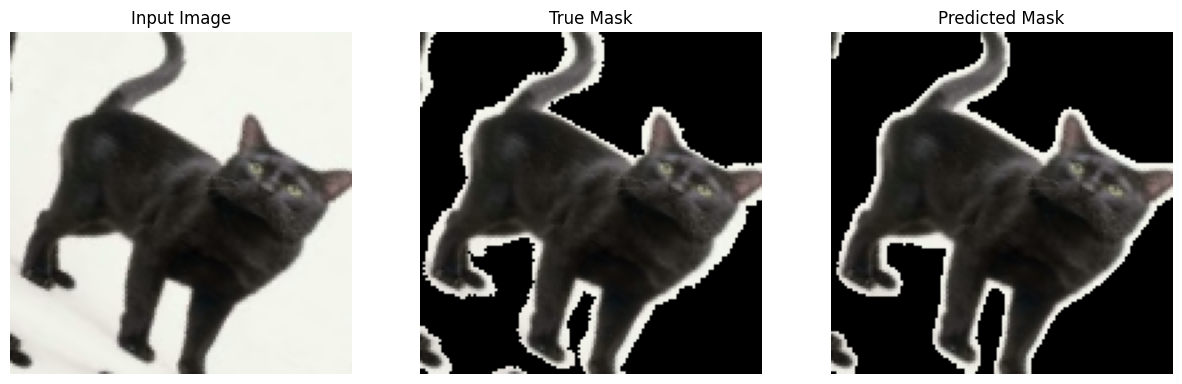

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


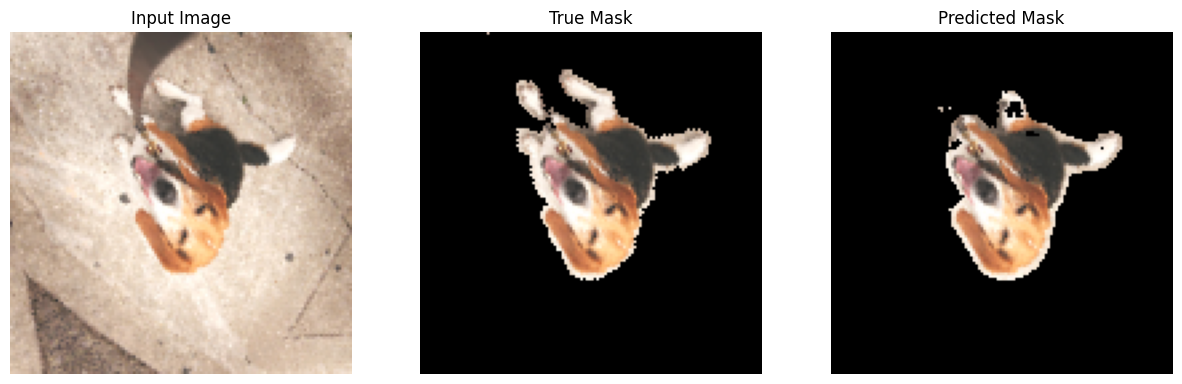

In [401]:
needed = 2
for (image,mask) in  training_set.unbatch().take(needed):
    mask, pred_mask= creat_masked_images(image,tf.argmax(mask, axis=-1),create_mask(unet.predict(image[tf.newaxis,])))
    display([image,mask, pred_mask])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


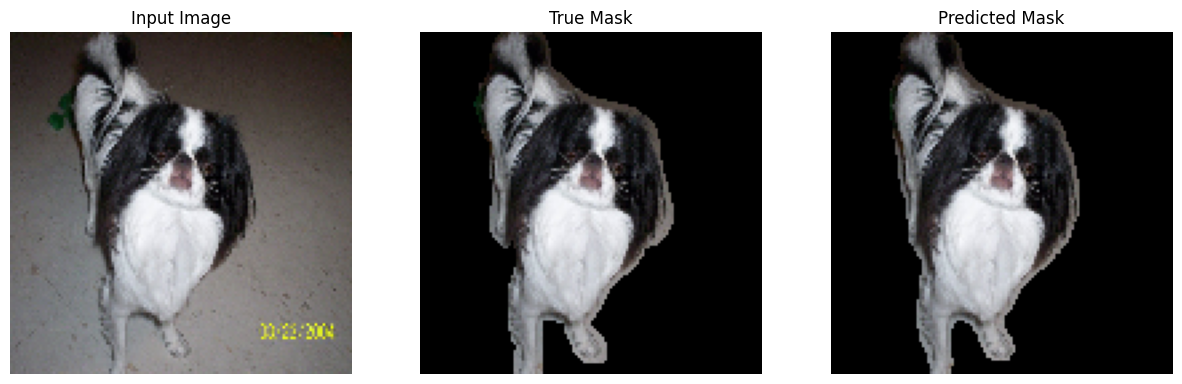

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


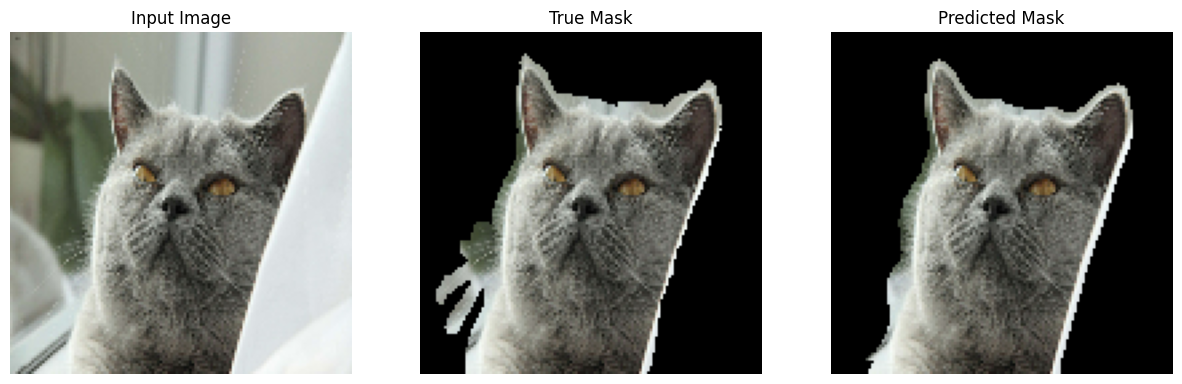

In [410]:
needed = 2
for (image,mask) in  validation_set.unbatch().take(needed):
    mask, pred_mask= creat_masked_images(image,tf.argmax(mask, axis=-1),create_mask(unet.predict(image[tf.newaxis,])))
    display([image,mask, pred_mask])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


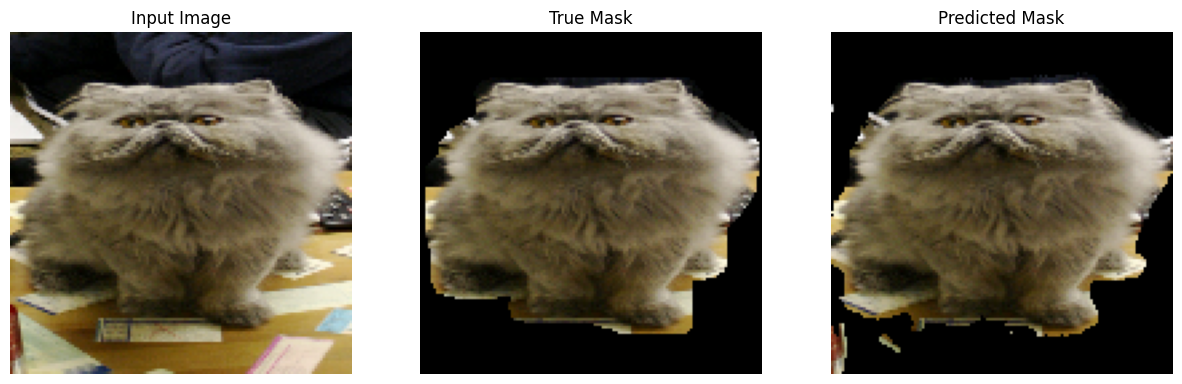

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


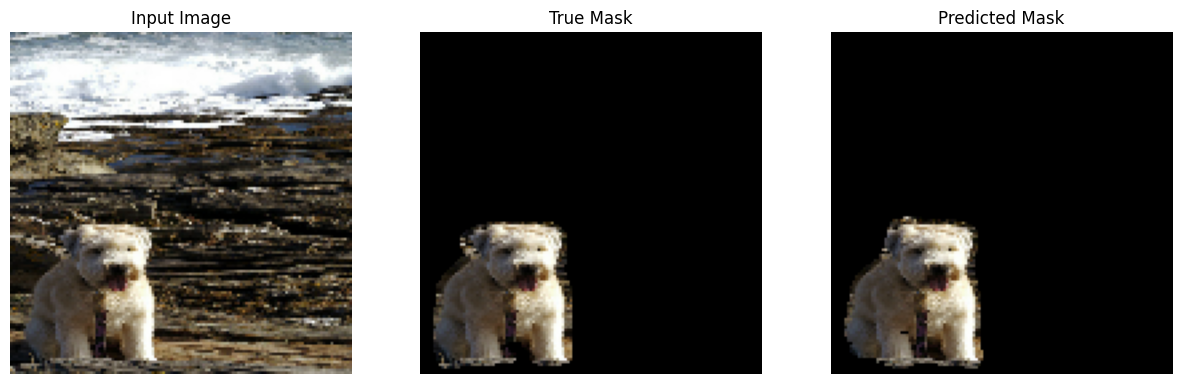

In [408]:
needed = 2
for (image,mask) in  test_set.unbatch().take(needed):
    
    mask, pred_mask= creat_masked_images(image,tf.argmax(mask, axis=-1),create_mask(unet.predict(image[tf.newaxis,])))
    display([image,mask, pred_mask])

In [406]:
mask= create_mask(unet.predict(image[tf.newaxis,]))
x = cv2.resize(mask.numpy(), (16,16), interpolation=cv2.INTER_NEAREST)
x

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 2, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1]], dtype=int32)